<h1 align='center'>Dropout as Regularization and Bayesian Approximation</h1>

 <h3 align='center'>Kovalev Evgeny, Chesakov Daniil, Vsevolod Glazov</h3>

## 3. Dropout Implementation

All our implementations are based on PyTorch. The model training is on GPU and all other tasks are on CPU (so readers who don't have GPUs can run our notebook). To switch between GPU/CPU, you can add/remove `.cuda()` in the code.

### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

### 5.2. Dropout as Bayesian Approximation in Regression Task

In this part, we show how to use dropout to obtain model uncertainty in regression tasks. We also compared the dropout as Bayesian approximation with Gaussian Process (GP) we learnt in AM207.

Here we use the **_lean 2000_irradiance_** concentrations dataset (example in [[2](#Reference)]) for demonstration. We load training set (provided in [[2](#Reference)]) and generate test data that is very different from the training set. The training dataset can be downloaded from our Google Drive shown at the beginning of this notebook.

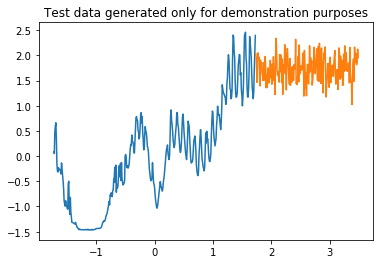

In [2]:
import pandas as pd
df = pd.read_table("data/lean2000_irradiance.txt",
                   comment='#',
                   header=None,
                   sep=' ',
                   names=["YEAR", "11yrCYCLE", "11yrCYCLE+BKGRND"])
X_train = df['YEAR'].values.reshape(-1, 1)
y_train = df['11yrCYCLE+BKGRND'].values.reshape(-1, 1)
X_test = np.arange(2001, 2200, 1)[:, None]

from sklearn.preprocessing import StandardScaler
SS_X = StandardScaler().fit(X_train)
X_train = SS_X.transform(X_train)
X_test = SS_X.transform(X_test)
y_train = StandardScaler().fit_transform(y_train)

plt.plot(X_train, y_train)
plt.plot(X_test, 1.75 * np.ones_like(X_test) + 0.25 * np.random.randn(*X_test.shape))
plt.title("Test data generated only for demonstration purposes")
plt.show()

We train a multilayer perceptron with 5 hidden layers, 1024 units in each layer, ReLU/Tanh non-linearities, and dropout with probability 0.2 after each weight layer. As pointed out by paper [[2](#Reference)], similar results can be obtained when using 4 hidden layers or dropout probability of 0.1.

We define the network with code below.

In [3]:
class MLP2(nn.Module):
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        super(MLP2, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)

Similar as last section, we implement a sklearn-like regressor for this MLP.

In [4]:
class MLP2Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu', \
                 max_epoch=1000, lr=0.005, weight_decay=1e-6):
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = MLP2(hidden_layers=hidden_layers, droprate=droprate, activation=activation)
        self.model.cuda()
        self.criterion = nn.MSELoss().cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def fit(self, X_train, y_train, verbose=True):
        X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor)).cuda()
        y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor)).cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, loss.item()))
        return self

And the training code is below. We load our trained models here.

In [5]:
### Below is training code, uncomment to train your own model... ###
### Note: You need GPU and CUDA to run this section ###

# Define networks
mlp2 = [MLP2Regressor(activation='relu'),
        MLP2Regressor(activation='tanh')]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(X_train, y_train,verbose=False) for mlp in mlp2]

# Save torch models
for ind, mlp in enumerate(mlp2):
    torch.save(mlp.model, 'models/irradiance_mlp2_'+str(ind)+'.pth')


# Load saved models to CPU
mlp2_models = [torch.load('models/irradiance_mlp2_'+str(ind)+'.pth',map_location={'cuda:0': 'cpu'}) for ind in [0,1]]

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2)
    (hidden1): Linear(in_features=1024, out_features=1024, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2)
    (hidden2): Linear(in_features=1024, out_features=1024, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2)
    (hidden3): Linear(in_features=1024, out_features=1024, bias=True)
    (relu3): ReLU()
    (dropout4): Dropout(p=0.2)
    (hidden4): Linear(in_features=1024, out_features=1024, bias=True)
    (relu4): ReLU()
    (dropout5): Dropout(p=0.2)
    (final): Linear(in_features=1024, out_features=1, bias=True)
  )
)
MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024, bias=True)
    (tanh0): Tanh()
    (dropout1): Dropout(p=0.2)
    (hidden1): Linear(in_features=1024, out_features=1024, bias=True)
    (tanh1): Tanh()
    (dropout2): Dropout(p=0.2)
    (hidden2): Linear(in_features=

Below is the function doing the simulation for the regressors (**keep dropout enabled to generate samples**). Here, we simulate 10000 times. The simulation is very slow since we have many data points.

In [6]:
def predict_reg(model, X, T=10000):
    X = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda())
    model = model.train()
    Yt_hat = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze()
    model = model.eval()
    y_pred = model(X).data.cpu().numpy()
    model = model.train()
    return y_pred, Yt_hat

The simulation on CPU takes a lot of time so we uses GPU instead. Generating simulation results thus **requires GPU and CUDA**, and therefore, we provide the stored simulation results and commented out the simulation code.

In [9]:
# Simulation below is very slow. Run with GPU! #
### Uncomment to simulate ###

mlp2_models = [torch.load('models/irradiance_mlp2_'+str(ind)+'.pth') for ind in [0,1]]
y_relu_pred, y_hat = predict_reg(mlp2_models[0], X_test)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)
y_tanh_pred, y_hat = predict_reg(mlp2_models[1], X_test)
y_tanh_mc = y_hat.mean(axis=0)
y_tanh_mc_std = y_hat.std(axis=0)
results = [y_relu_pred,y_relu_mc,y_relu_mc_std,y_tanh_pred,y_tanh_mc,y_tanh_mc_std]
results = [x.reshape(-1).astype(str).tolist() for x in results]
open("models/mlp2_sim_irradiance_results.txt","w").write('\n'.join([','.join(res) for res in results]))


# Load saved simulation results
results = [res_array.split(',') for res_array in 
                      open("models/mlp2_sim_irradiance_results.txt","r").read().split('\n')]
results = np.array(results,dtype='f')
y_relu_pred,y_relu_mc,y_relu_mc_std,y_tanh_pred,y_tanh_mc,y_tanh_mc_std = results

We can compare the uncertainty we get through dropout with the uncertainty we get from a Gaussian process (GP). Below is the definition of our GP and since pymc is pretty slow, we commented out the sampling code and provide the generated samples.

We check the convergence of our GP model below:

The above tests demonstrate the convergence of the model.

Now, we use `sample_ppc` to generate posterior predictive for our test data. As above, we provide saved results since `sample_ppc` is slow.

Next, we compare those models for regression. The figures below is very similar to figures in paper [[2](#Reference)]. We intentionally made the plot titles same with those in the paper and the paper calls dropout as Monte Carlo dropout (MC dropout).

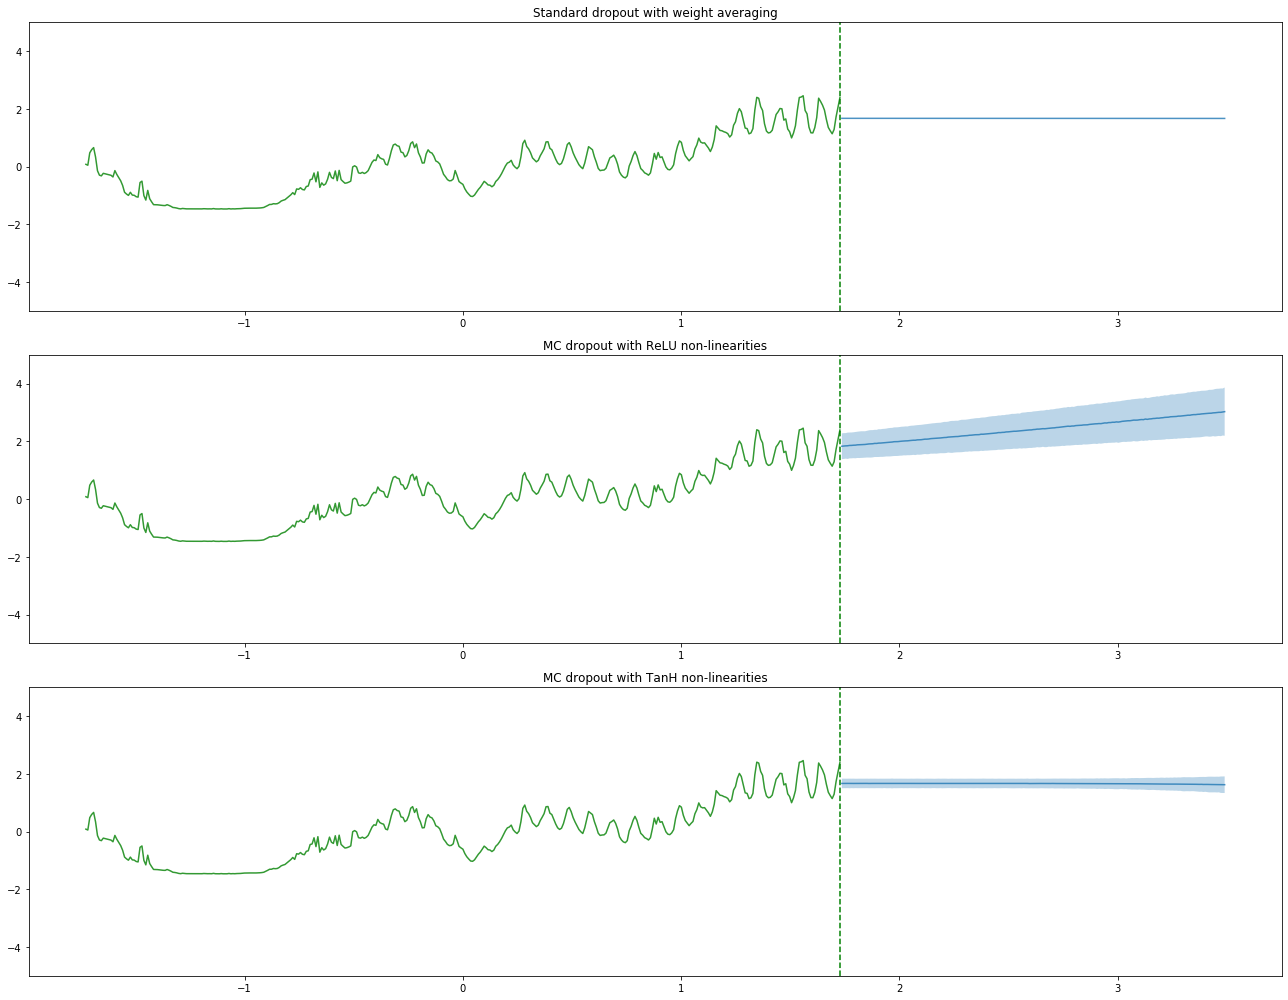

In [8]:
plt.figure(figsize=(18, 14))

plt.subplot(3, 1, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-5, 5]);

# plt.subplot(2, 2, 2)
# plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
# plt.plot(X_test.squeeze(), y_gp_pred, alpha=0.8);
# plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
# plt.fill_between(X_test.squeeze(), y_gp_pred-2*y_gp_std, y_gp_pred+2*y_gp_std, alpha=0.3);
# plt.title('Gaussian process with SE covariance function');
# plt.ylim([-20, 20]);

plt.subplot(3, 1, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-5, 5]);

plt.subplot(3, 1, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-5, 5]);

plt.tight_layout();

As we can see, the dropout network with ReLU non-linearities and the Gaussian process (GP) model successfully show the uncertainty for points away from the training data points. The uncertainty estimates are different since they correpond to different Gaussian process covariance functions. The uncertainty of dropout network with Tanh non-linearities doesn't increase far from the data, presumably because Tanh saturates whereas ReLU does not, as explained by in [[2](#Reference)]

## 6. Conclusions

This tutorial focuses on paper [[1](#Reference)] and [[2](#Reference)]. We showed the math, implementation and usage of dropout and the details of dropout as regularization. The dropout as regularization successfully reduced the overfitting of deep learning models and we achived higher accuracy on the test set. Regularization is not new, and we have seen other regularization techniques (L1 and L2) in AM207 lectures.

In addition, we showed dropout as Bayesian approximation (obtain model uncertainty [[2](#Reference)]). For regression tasks, we also compared the deep neural network with dropout as Bayesian approximation with the Gaussian Process (GP) we learnt in AM207. From the figure, we see both models successfully show the uncertainty for points away from the training data points. According to [[2](#Reference)], the uncertainty estimates are different since they correpond to different Gaussian process covariance functions. Since GP and neural networks with dropout are similar, in large dataset, we can use neural networks with dropout to approximate GP (with large amount of data, GP has very large covariance matrix and it's hard to fit).

## Reference

[1] [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580.pdf)

[2] [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142.pdf)

[3] [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf)